# In this notebook we are going to train the model that we are going to use for our final purposes

In [1]:
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Input
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## Load Training, Validation and Test Data

In [2]:
pickle_in =  open("data\X_train.data","rb")
X_train = pickle.load(pickle_in)
pickle_in.close()

pickle_in =  open("data\X_validation.data","rb")
X_validation = pickle.load(pickle_in)
pickle_in.close()

pickle_in =  open("data\X_test.data","rb")
X_test = pickle.load(pickle_in)
pickle_in.close()

pickle_in =  open("data\y_train.data","rb")
y_train = pickle.load(pickle_in)
pickle_in.close()

pickle_in =  open("data\y_validation.data","rb")
y_validation = pickle.load(pickle_in)
pickle_in.close()

pickle_in =  open("data\y_test.data","rb")
y_test = pickle.load(pickle_in)
pickle_in.close()

## Model preparation

In [3]:
img_size = 224
channels = 3


aug = ImageDataGenerator(rotation_range = 20,
                         zoom_range = 0.15,
                         width_shift_range = 0.2,
                         height_shift_range = 0.2,
                         shear_range = 0.15,
                         horizontal_flip = True,
                         fill_mode = "nearest")


feature_extractor_layer = ResNet50V2(weights = "imagenet", #pretrained deep neural network with imaagenet dataset
                                   include_top = False, # do not inclued the fully connected layers because we are applying fine tuning
                                   input_tensor = Input(shape = (img_size,img_size,channels))) #size of the input

feature_extractor_layer.trainable = False #fine tuning

model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Flatten(name="flatten"),
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='sigmoid', name='output') #2 nodes one for each class
])

LR = 1e-5

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = LR),
              loss = "binary_crossentropy", 
              metrics = ["accuracy"])

callback = tf.keras.callbacks.ModelCheckpoint('model_last.h5', 
                                              monitor = 'val_loss', 
                                              mode='min',
                                              verbose = 1)


## Train of the Neural Network

In [4]:
EPOCHS = 30
BS = 128

history = model.fit(aug.flow(X_train, y_train, batch_size=BS), 
                    epochs = EPOCHS,
                    steps_per_epoch = len(X_train) // BS, 
                    validation_data = (X_validation, y_validation), 
                    callbacks = [callback])


Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 0.3833 - accuracy: 0.8830
Epoch 1: saving model to model_last.h5
17/17 [==============================] - 47s 2s/step - loss: 0.3833 - accuracy: 0.8830 - val_loss: 0.0698 - val_accuracy: 0.9804
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 0.0791 - accuracy: 0.9816
Epoch 2: saving model to model_last.h5
17/17 [==============================] - 36s 2s/step - loss: 0.0791 - accuracy: 0.9816 - val_loss: 0.0591 - val_accuracy: 0.9856
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 0.0373 - accuracy: 0.9926
Epoch 3: saving model to model_last.h5
17/17 [==============================] - 36s 2s/step - loss: 0.0373 - accuracy: 0.9926 - val_loss: 0.0484 - val_accuracy: 0.9869
Epoch 4/30
17/17 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.9936
Epoch 4: saving model to model_last.h5
17/17 [==============================] - 36s 2s/step - loss: 0.0268 - accuracy: 0

## Results

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


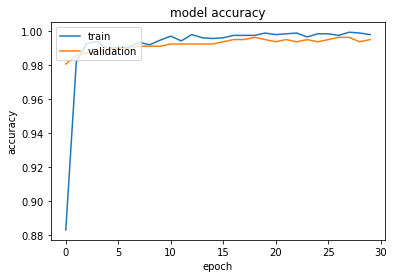

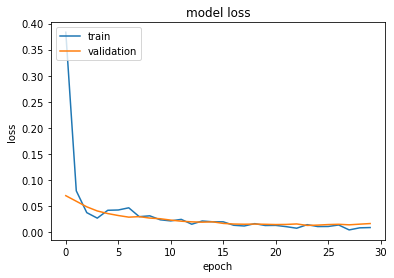

In [5]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Performances on the Test Set

In [7]:
import numpy as np
predictions = model.predict(X_test)
predicted = []
for with_mask,without_mask in predictions:
    if(with_mask > without_mask):
        predicted.append([1,0])
    else:
        predicted.append([0,1])
predicted = np.array(predicted)

In [8]:
def transform_to_labels(array):
    labels = []
    for mask,no_mask in array:
        if(mask == 1):
            labels.append(0)
        else:
            labels.append(1)
    return np.array(labels)

In [9]:
predicted_labels = transform_to_labels(predicted)
y_test = transform_to_labels(y_test)

In [10]:
print("Accuracy on the Test Set : " , ((len(y_test) - np.count_nonzero((predicted_labels + y_test) == 1)) / len(y_test)))

Accuracy on the Test Set :  0.9934810951760105
